In [10]:
import pandas as pd
from datetime import timedelta
import json

def input_timings(num_questions):
    timings = []
    print("Enter the timings (HH:MM:SS) taken for each question starting from the total time (e.g., 01:15:00):")
    for i in range(num_questions):
        time_str = input(f"Time remaining after question {i+1} (HH:MM:SS): ")
        h, m, s = map(int, time_str.split(':'))
        time_remaining = timedelta(hours=h, minutes=m, seconds=s)
        timings.append(time_remaining)
    return timings

def analyze_timings(timings, total_time):
    total_time_delta = timedelta(minutes=total_time)
    data = {
        'Question': list(range(1, len(timings) + 1)),
        'Time Remaining': timings,
        'Time Spent': [total_time_delta - t for t in timings]
    }
    df = pd.DataFrame(data)
    df['Time Spent on Question'] = df['Time Spent'].diff().fillna(df['Time Spent'][0])
    return df

def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Jupyter Notebook specific cells

# Step 1: Enter the name of the paper
paper_name = input("Enter the name of the paper: ")

# Step 2: Enter the number of questions
num_questions = int(input("Enter the number of questions: "))

# Step 3: Input timings for each question
timings = input_timings(num_questions)

# Step 4: Analyze the timings
total_time = 75  # total time for the paper in minutes
analysis_df = analyze_timings(timings, total_time)

# Step 5: Format the timedelta columns for better readability
analysis_df['Time Remaining'] = analysis_df['Time Remaining'].apply(format_timedelta)
analysis_df['Time Spent'] = analysis_df['Time Spent'].apply(format_timedelta)
analysis_df['Time Spent on Question'] = analysis_df['Time Spent on Question'].apply(format_timedelta)

# Display the analysis
print("\nTime Analysis:")
print(analysis_df.to_string(index=False))

# Convert the DataFrame to a dictionary
analysis_dict = analysis_df.to_dict(orient='list')
# Add the paper name to the dictionary
analysis_dict['Paper Name'] = paper_name

# Write the dictionary to a JSON file
with open('time_analysis.json', 'w') as json_file:
    json.dump(analysis_dict, json_file, indent=4)

print(f"\nTime analysis has been saved to 'time_analysis.json'")


ValueError: invalid literal for int() with base 10: ''

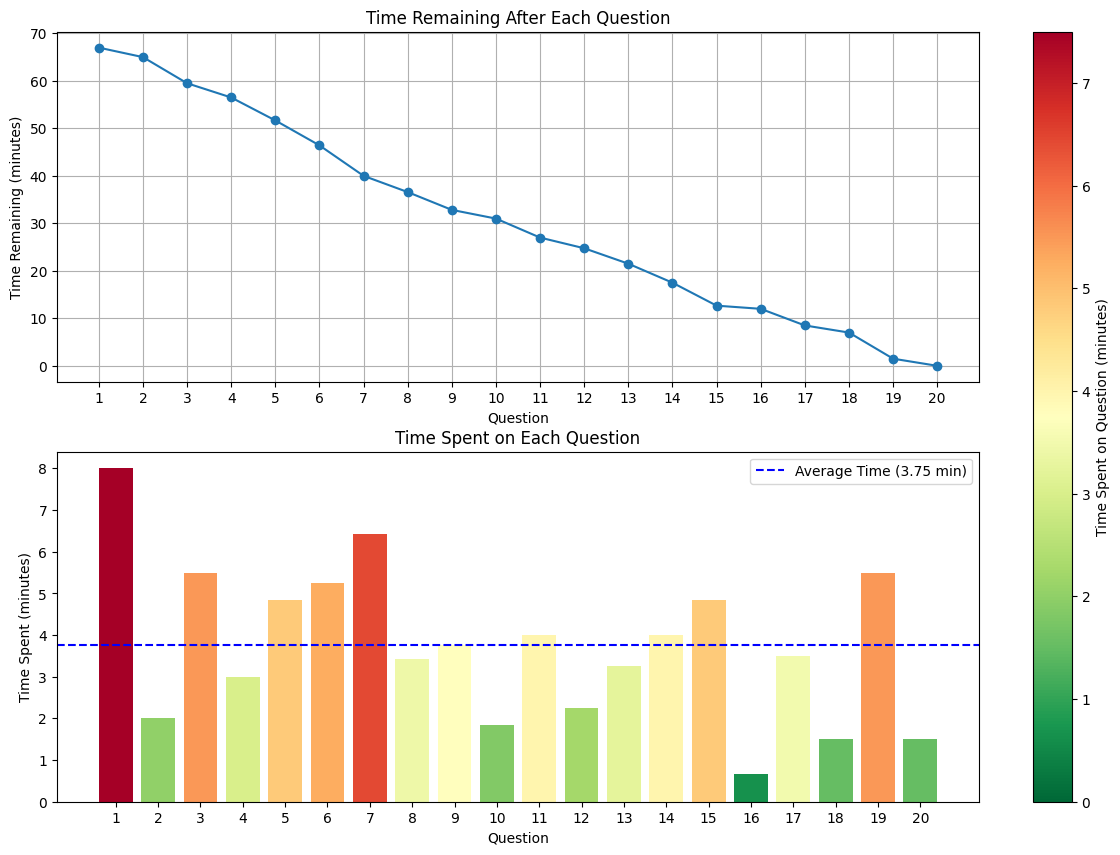

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import timedelta
import numpy as np
import matplotlib.colors as mcolors

# Load the JSON file
with open('time_analysis.json', 'r') as json_file:
    analysis_dict = json.load(json_file)

# Convert the loaded dictionary back to a DataFrame
analysis_df = pd.DataFrame(analysis_dict)

# Convert time columns from string to timedelta for plotting
def parse_timedelta(time_str):
    h, m, s = map(int, time_str.split(':'))
    return timedelta(hours=h, minutes=m, seconds=s)

analysis_df['Time Remaining'] = analysis_df['Time Remaining'].apply(parse_timedelta)
analysis_df['Time Spent'] = analysis_df['Time Spent'].apply(parse_timedelta)
analysis_df['Time Spent on Question'] = analysis_df['Time Spent on Question'].apply(parse_timedelta)

# Convert timedelta to total minutes for plotting
analysis_df['Time Remaining (m)'] = analysis_df['Time Remaining'].dt.total_seconds() / 60
analysis_df['Time Spent (m)'] = analysis_df['Time Spent'].dt.total_seconds() / 60
analysis_df['Time Spent on Question (m)'] = analysis_df['Time Spent on Question'].dt.total_seconds() / 60

# Calculate average time spent per question
average_time_per_question = analysis_df['Time Spent on Question (m)'].mean()

# Normalize the time spent for color mapping
norm = plt.Normalize(0, 2 * average_time_per_question)  # assuming 2 * average as a reasonable upper limit
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
sm.set_array([])

# Apply colors based on normalized values
colors = sm.to_rgba(analysis_df['Time Spent on Question (m)'])

# Plotting
plt.figure(figsize=(14, 10))

# Plot 1: Time Remaining after each question
plt.subplot(2, 1, 1)
plt.plot(analysis_df['Question'], analysis_df['Time Remaining (m)'], marker='o')
plt.title('Time Remaining After Each Question')
plt.xlabel('Question')
plt.xticks(analysis_df['Question'])  # Show all integers on the x-axis
plt.ylabel('Time Remaining (minutes)')
plt.grid(True)

# Plot 2: Time Spent on Each Question with Average Line and Color Gradient
plt.subplot(2, 1, 2)
bars = plt.bar(analysis_df['Question'], analysis_df['Time Spent on Question (m)'], color=colors)
plt.axhline(y=average_time_per_question, color='blue', linestyle='--', label=f'Average Time ({average_time_per_question:.2f} min)')
plt.title('Time Spent on Each Question')
plt.xlabel('Question')
plt.xticks(analysis_df['Question'])  # Show all integers on the x-axis
plt.ylabel('Time Spent (minutes)')
plt.legend()

# Add color bar to indicate the scale
cbar = plt.colorbar(sm, ax=plt.gcf().axes, orientation='vertical', fraction=.1)
cbar.set_label('Time Spent on Question (minutes)')

plt.show()
